In [1]:
import pyforest
import itertools
import warnings
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../Data/dataset_final.csv')
df.set_index(pd.to_datetime(df.date),inplace=True)
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)
df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,btc_price,gold_price,oil_wti_price,sp500_close,btc_num_trans,btc_google_search,btc_dr,gold_dr,oil_dr,sp500_dr,BVOL,GVOL,OVOL,VIX
date,,,,,,,,,,,,,,
2015-01-15,211.91,1352.8,46.37,1992.67,102309.0,3,0.568670,0.021141,-0.044705,-0.009291,0.853974,0.344132,0.344950,22.39
2015-01-16,199.46,1364.9,48.49,2019.42,104699.0,3,-0.060548,0.008905,0.044705,0.013335,0.857286,0.348453,0.346061,20.95
2015-01-20,208.00,1377.4,46.79,2022.55,98485.0,3,0.041924,0.009116,-0.035688,0.001549,0.857176,0.348518,0.346647,19.89
2015-01-21,225.51,1378.4,47.85,2032.12,98485.0,3,0.080826,0.000726,0.022402,0.004720,0.893605,0.350149,0.347336,18.85
2015-01-22,226.32,1390.2,45.93,2063.15,93698.0,3,0.003585,0.008524,-0.040953,0.015154,0.904949,0.351242,0.343230,16.40


We split dataset set into training data and test data. Testing data consist last 3 months (February 2020, March 2020, April 2020) data and training data consist rest of the dataset.

In [3]:
df['mean_dr'] = np.mean(df[['gold_dr','oil_dr','sp500_dr']],axis=1)
df['var_dr'] = np.var(df[['gold_dr','oil_dr','sp500_dr']],axis=1)
df['var_dr'] = df.var_dr.diff().fillna(0)
test_data = pd.concat([df['2020-02'],df['2020-03'],df['2020-04']],axis=0)
train_data = df[:-len(test_data)]
test_data = test_data.reset_index()
train_data = train_data.reset_index()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The ARMAX Model : 
    ![alt text](armax.jpg)
    
ARMAX (p, q, b) model from Baillie (1980) to explain Bitcoin returns
using Equation (2), where p is autoregressive term, q is moving average term and b is exogenous inputs term.

<b>What is an exogenous variable?</b>
<br><br>
Well, X is the exogenous variable and it can be any variable we’re interested in.
<br><br>
It can be a time-varying measurement like the inflation rate or the price of a different index. Or a categorical variable separating the different days of the week. It can also be a Boolean accounting for the special festive periods. Finally, it can stand for a combination of several different external factors.
<br><br>
The idea is that it can be any other variable or variables that can affect prices, as long as we have the data available.
Such outside factors are known as exogenous variables in our regression. We use their values to predict and explain the one we’re interested in, which happens to be current prices in our case.

In [4]:
def plot_series(origional_val,forecast_val,order):
    plt.figure(figsize=(10,6))
    plt.plot(origional_val,label = 'origional_val')
    plt.plot(forecast_val, label = 'forecast_val')
    plt.fill_between(test_data.index,origional_val,forecast_val,color='skyblue')
    ttl = 'ARMAX('+ str(order[0]) +','+str(order[0])+')'
    plt.title(ttl)
    plt.legend()#(origional_val, forecast_val), ('origional_val', 'forecast_val')
    plt.show()

In [5]:
def apply_armax(train_data,test_data,exog_var):
    p = q = range(0,9) # p and q can be either 0, 1, or 2
    pq = list(itertools.product(p,q))
    combs = {}
    aics = []
    # Grid Search to find best ARMAX model with minimym aic
    for combination in pq:
        try:
            model = ARMA(train_data.btc_dr, order=combination,exog=train_data[exog_var])
            model = model.fit()
            combs.update({model.aic : [combination]})
            aics.append(model.aic)
        except:
            continue
    best_aic = min(aics)
    order=combs[best_aic][0]
    print('ARMAX',order,' have minimum aic value.')
    return order

def forecast(train_data,test_data,order,exog_var):
    model = ARMA(train_data['btc_dr'], order=order, exog=train_data[exog_var])
    result = model.fit()
    prediction = result.predict(start=0,exog=test_data[exog_var])
    print('MSE for Training Dataset : ',np.sqrt(mean_squared_error(train_data.btc_dr,prediction)))
    forecast = result.forecast(steps= len(test_data),exog=test_data[exog_var])
    print('MSE for forcasted Values : ',np.sqrt(mean_squared_error(test_data.btc_dr,forecast[0])))
    return forecast

### Apply ARMAX model (exogeneous variable = gold_dr)

ARMAX (4, 4)  have minimum aic value.


<IPython.core.display.Javascript object>

MSE for Training Dataset :  0.04700286440776945


<IPython.core.display.Javascript object>

MSE for forcasted Values :  0.08022023379111763


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

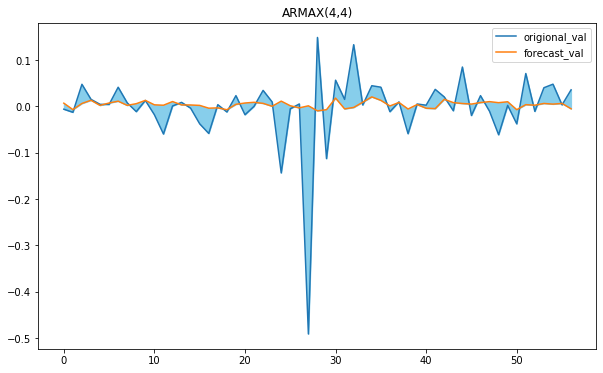

In [6]:
best_order = apply_armax(train_data,test_data,'gold_dr')
forecast_dr = forecast(train_data,test_data,best_order,'gold_dr')
forecast_dr = pd.DataFrame({'Forecast':forecast_dr[0]})
plot_series(test_data.btc_dr,forecast_dr.Forecast,best_order)

### Apply ARMAX model (exogeneous variable = sp500_dr)

ARMAX (3, 6)  have minimum aic value.


<IPython.core.display.Javascript object>

MSE for Training Dataset :  0.04700026958513773


<IPython.core.display.Javascript object>

MSE for forcasted Values :  0.08226202843828562


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

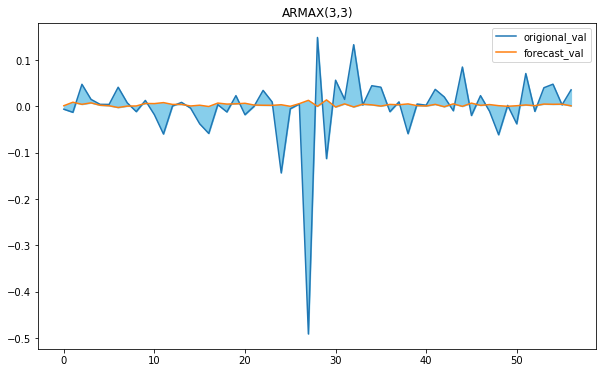

In [7]:
best_order = apply_armax(train_data,test_data,'sp500_dr')
forecast_dr = forecast(train_data,test_data,best_order,'sp500_dr')
forecast_dr = pd.DataFrame({'Forecast':forecast_dr[0]})
plot_series(test_data.btc_dr,forecast_dr.Forecast,best_order)

### Apply ARMAX model (exogeneous variable = oil_dr)

ARMAX (3, 6)  have minimum aic value.


<IPython.core.display.Javascript object>

MSE for Training Dataset :  0.047002511087307096


<IPython.core.display.Javascript object>

MSE for forcasted Values :  0.08101373630702195


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

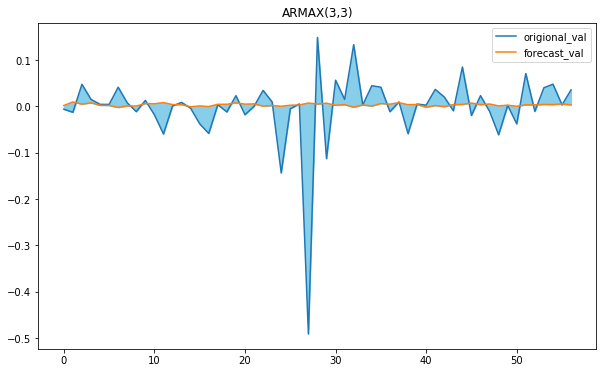

In [8]:
best_order = apply_armax(train_data,test_data,'oil_dr')
forecast_dr = forecast(train_data,test_data,best_order,'oil_dr')
forecast_dr = pd.DataFrame({'Forecast':forecast_dr[0]})
plot_series(test_data.btc_dr,forecast_dr.Forecast,best_order)

### Apply ARMAX model (exogeneous variable = mean_dr)

ARMAX (4, 4)  have minimum aic value.


<IPython.core.display.Javascript object>

MSE for Training Dataset :  0.04706820529444631


<IPython.core.display.Javascript object>

MSE for forcasted Values :  0.08002832932776593


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

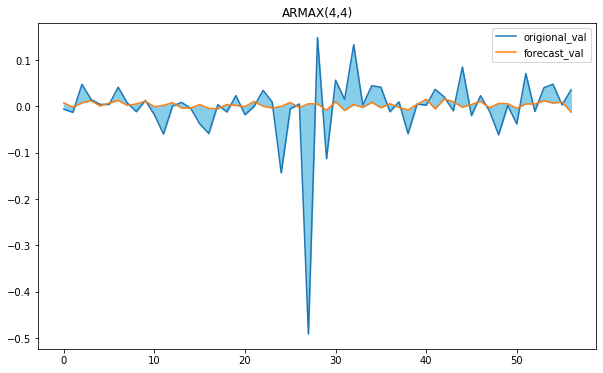

In [11]:
best_order = apply_armax(train_data,test_data,'mean_dr')
forecast_dr = forecast(train_data,test_data,best_order,'mean_dr')
forecast_dr = pd.DataFrame({'Forecast':forecast_dr[0]})
plot_series(test_data.btc_dr,forecast_dr.Forecast,best_order)

### Apply ARMAX model (exogeneous variable = var_dr)

ARMAX (5, 2)  have minimum aic value.


<IPython.core.display.Javascript object>

MSE for Training Dataset :  0.04711197857570211


<IPython.core.display.Javascript object>

MSE for forcasted Values :  0.08345037195937435


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

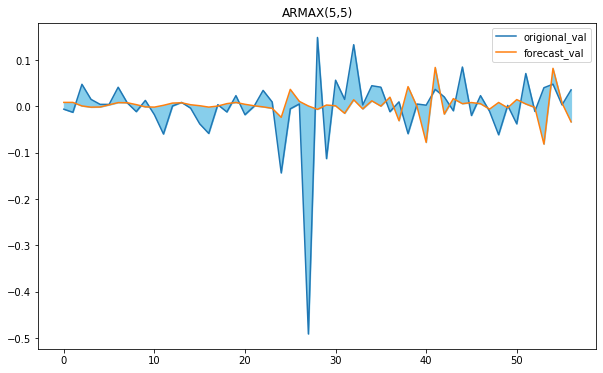

In [10]:
best_order = apply_armax(train_data,test_data,'var_dr')
forecast_dr = forecast(train_data,test_data,best_order,'var_dr')
forecast_dr = pd.DataFrame({'Forecast':forecast_dr[0]})
plot_series(test_data.btc_dr,forecast_dr.Forecast,best_order)